In [1]:
## this cell is hidden in sphinx (see the cell metadata)
import expectexception

# `inlinet` API tutorial

## Interactive Version
Launch Binder for an interactive version of this tutorial!

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/quatrope/pycf3/HEAD?filepath=docs%2Fsource%2Ftutorial.ipynb)

## Introduction

This tutorial is a guide on how to interact with the two Cosmicflows-3 Distance-Velocity Calculators in a Python code. These calculators are featured in [Kourkchi et al. 2020, AJ, 159, 67](https://ui.adsabs.harvard.edu/abs/2020AJ....159...67K/abstract).


`pycf3` present an [OO](https://en.wikipedia.org/wiki/Object-oriented_programming) API to access the same capabilities of http://edd.ifa.hawaii.edu/NAMcalculator/  and http://edd.ifa.hawaii.edu/CF3calculator/ .
Please be gentle with the server.

The first required step is to import the project

In [2]:
import pycf3

## Example 1:  Sending a request to the NAM D-V calcualtor 

First, let's create the **NAM Client**

In [3]:
nam = pycf3.NAM()
nam

NAM(calculator='NAM', cache_dir='/home/ehsan/pycf3_data/_cache_', cache_expire=None)

Then the basic functionality of the NAM are provided in two different methods

- `calculate_distance(velocity, <coordinates>)` to calculate a **distance** based on a given *velocity*.
- `calculate_velocity(distance, <coordinates>)` to calculate a **velocity** based on a given *distance*.

The `<coordinates>` parameters can be expressed in `ra, dec` (equatorial), `glon, glat` (galactic) or 
`sgl, sgb` (supergalactic) coordinates. You need to provide both components of a coordinate. Please note that multiple coordinate systems cannot be mixed.


Now, let's assume we want to generate the same query as it appears in the following Figure

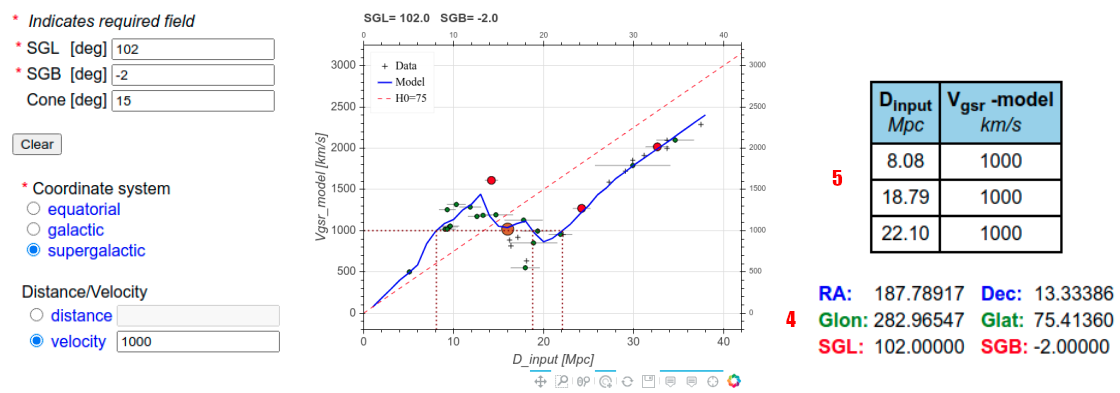

Here is how to send the same request in a Python code:

In [4]:
result = nam.calculate_distance(velocity=1000, sgl=102, sgb=-2)
result

Result - NAM(velocity=1000, sgl=102, sgb=-2)
+----------+-----------------+---------------------------------------+
| Observed | Distance (Mpc)  | [ 8.08088613 18.78629089 22.09785028] |
|          | Velocity (Km/s) | 1000.0                                |
+----------+-----------------+---------------------------------------+

> Note: You can click `Show/Hide Raw` to check the raw response from the server

The provided coordinates at different coordinate systems can be extracted as follows

In [5]:
result.calculated_at_

CalculatedAt(ra=187.7891703346409, dec=13.333860121247609, glon=282.9654677357161, glat=75.4136002414933, sgl=102.0, sgb=-2.0)

and the corresponding **distance/velocity** values are available at:

In [6]:
result.observed_velocity_

1000.0

In [7]:
result.observed_distance_

array([ 8.08088613, 18.78629089, 22.09785028])

In addition, the entire raw response, as it is returned by the **EDD** server, are packaged in the `json_` attribute in the form of a Python dictionary

In [8]:
result.json_

{'message': 'Success',
 'RA': 187.7891703346409,
 'Dec': 13.333860121247609,
 'Glon': 282.9654677357161,
 'Glat': 75.4136002414933,
 'SGL': 102.0,
 'SGB': -2.0,
 'velocity': 1000.0,
 'distance': [8.08088612690689, 18.786290885088945, 22.097850275812398]}

## Example 2: How to extract the radial velocity of an object at a given distance in NAM

In [9]:
nam.calculate_velocity(distance=30, sgl=102, sgb=-2)

Result - NAM(distance=30, sgl=102, sgb=-2)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [30.]              |
|          | Velocity (Km/s) | 1790.9019256321444 |
+----------+-----------------+--------------------+

## Example 3: Sending a request to the Cosmicflows-3 D-V calculator (d < 200 Mpc)

We are trying to reproduce this query in Python

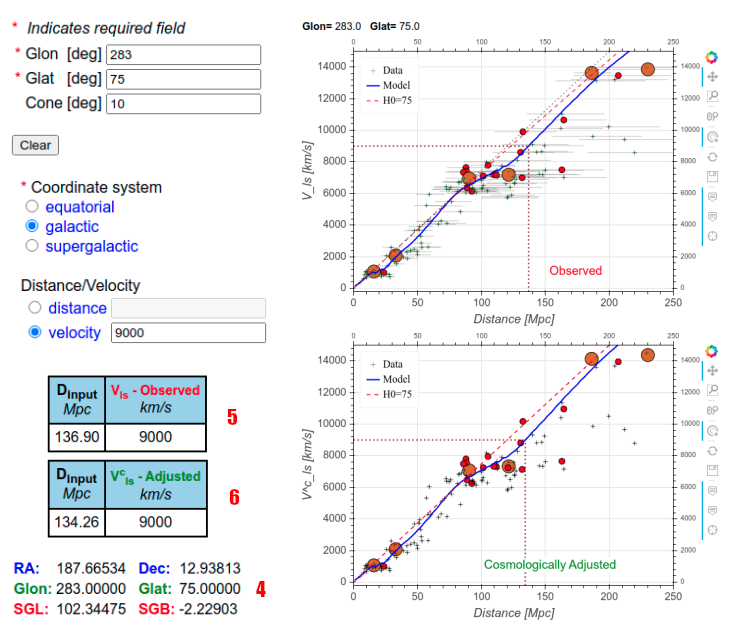

As stated before, first we need to create a **Cosmic Flows-3 Client**

In [10]:
cf3 = pycf3.CF3()
cf3

CF3(calculator='CF3', cache_dir='/home/ehsan/pycf3_data/_cache_', cache_expire=None)

Let's calculate the distance

In [11]:
result = cf3.calculate_distance(velocity=9000, glon=283, glat=75)
result

Result - CF3(velocity=9000, glon=283, glat=75)
+----------+-----------------+----------------+
| Observed | Distance (Mpc)  | [136.90134347] |
|          | Velocity (Km/s) | 9000.0         |
+----------+-----------------+----------------+
| Adjusted | Distance (Mpc)  | [134.26214472] |
|          | Velocity (Km/s) | 9000.0         |
+----------+-----------------+----------------+

Similar to NAM, **coordinates** can be accessed with `result.calculated_at_` and **velocity/distance** with `result.observed_velocity_` and `result.observed_distance_` respectively.

In addition, CF3 provides an adjusted version of the **velocity/distance**, that are available in `result.adjusted_distance_` and `result.adjusted_velocity_` . For further details on the adjustments you can visit [Here](http://edd.ifa.hawaii.edu/CF3calculator/).

In [12]:
result.adjusted_distance_

array([134.26214472])

In [13]:
result.adjusted_velocity_

9000.0

> Note: The NAM client also has the *adjusted_* values but all are `None`.

## Example 4: How to obtain the radial velocity at a given distance with CF3 

In [14]:
cf3.calculate_velocity(distance=180, ra=187, dec=13)

Result - CF3(distance=180, ra=187, dec=13)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12515.699706446017 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12940.58481990226  |
+----------+-----------------+--------------------+

----

## PyCF3 Cache system

By default, any any client instance is created with a cache that prevent to send the same request twice. For example, let's make a similar query twice and measure the calculation time.

> Note: We are using the `pycf3.CF3` client as an example, but any other `pycf3` calculator has the same functionalities.

In [15]:
cf3 = pycf3.CF3()

In [16]:
## this cell is hidden in sphinx (see the cell metadata)
cf3.cache.clear()

4

In [17]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13)

CPU times: user 6.53 ms, sys: 1.02 ms, total: 7.56 ms
Wall time: 11.6 s


Result - CF3(distance=180, ra=187, dec=13)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12515.699706446017 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12940.58481990226  |
+----------+-----------------+--------------------+

In [18]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13)

CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 2.86 ms


Result - CF3(distance=180, ra=187, dec=13)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12515.699706446017 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12940.58481990226  |
+----------+-----------------+--------------------+

Evidently, the first time execution lasts for about **10 seconds** while the second time execution is of the order of **ms**. This is achieved by storing the results on the local hard drive in order to avoid the successive execution of similar requests (by default a folder called `pycf3_data`, is created in the user home directory)

As expected, if the query is altered by asking for another declination, the process is going to be slow again:

In [19]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13.5)

CPU times: user 3.98 ms, sys: 4.03 ms, total: 8.01 ms
Wall time: 12.2 s


Result - CF3(distance=180, ra=187, dec=13.5)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12512.725297090401 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12937.406568949371 |
+----------+-----------------+--------------------+

and the execution of the same query is fast again

In [20]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13.5)

CPU times: user 1.68 ms, sys: 357 µs, total: 2.04 ms
Wall time: 1.37 ms


Result - CF3(distance=180, ra=187, dec=13.5)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12512.725297090401 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12937.406568949371 |
+----------+-----------------+--------------------+

In addition, it is beneficial to recycle the results that are not "too older" than an expiration time. In these cases, you can set how many second your local data will be available by adding the parameter `cache_expire` when you create the *CF3* client.

In [21]:
cf3 = pycf3.CF3(cache_expire=2)

At this point the new cf3 instance shares the same default-cache of the previous one. Now, if we execute any of the previous requests, the process would be fast. As seen, it's only taking a few milliseconds.

In [22]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13)

CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 1.65 ms


Result - CF3(distance=180, ra=187, dec=13)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12515.699706446017 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12940.58481990226  |
+----------+-----------------+--------------------+

Yo can remove the entire "cached" data by calling the command

In [23]:
cf3.cache.clear()

2

In [24]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13.5)

import time
time.sleep(3)  # lets sleep 3 seconds

CPU times: user 6.2 ms, sys: 3.32 ms, total: 9.52 ms
Wall time: 14.5 s


because we waited to long, the next query will be slow again

In [25]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13.5)

CPU times: user 6.5 ms, sys: 5.01 ms, total: 11.5 ms
Wall time: 11.7 s


Result - CF3(distance=180, ra=187, dec=13.5)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12512.725297090401 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12937.406568949371 |
+----------+-----------------+--------------------+

However, if we don't wait until the cached outcomes are expired, the process would be quick.

In [26]:
%%time
cf3.calculate_velocity(distance=180, ra=187, dec=13.5)

CPU times: user 0 ns, sys: 2.3 ms, total: 2.3 ms
Wall time: 1.53 ms


Result - CF3(distance=180, ra=187, dec=13.5)
+----------+-----------------+--------------------+
| Observed | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12512.725297090401 |
+----------+-----------------+--------------------+
| Adjusted | Distance (Mpc)  | [180.]             |
|          | Velocity (Km/s) | 12937.406568949371 |
+----------+-----------------+--------------------+

### Changing the cache backend

The entire cache backend of pycf3 was created with **DiskCache** (http://www.grantjenks.com/docs/diskcache/)

You can change your cache location (to store different datasets for example) by providing another `diskcache.Cache` or `diskcache.FanoutCache` instance.

```python

import diskcache as dcache

cache = dcache.FanoutCache(
    directory="my/cache/directory")

# let make our data valid for 24 hours
cf3 = pycf3.CF3(cache=cache, cache_expire=86400)

```

Finally, to completely deactivate the cache system, pycf3 can be forced to ignore the cache system by setting cache to `NoCache`.

In [27]:
cf3 = pycf3.CF3(cache=pycf3.NoCache())
cf3

CF3(calculator='CF3', cache_dir='', cache_expire=None)

----

## PyCF3 Retry

By default any calculator instance try **3 times** to perform a request.
if you want to customize the number of attempts, you need to change the default `session` of the instance.

> Note: We are using the `pycf3.CF3` client as an example, but any other `pycf3` calculator has the same functionalities.

For example if you want to try 2 times:

In [28]:
session = pycf3.RetrySession(retries=2)
cf3 = pycf3.CF3(session=session)

Also if you want to only wait for some arbitrary number of seconds between any request you can add the `timeout=<SECONDS>` to any search request.

In [29]:
## this cell is hidden in sphinx (see the cell metadata)
cf3.cache.clear()

1

In [30]:
# no more than 5 seconds between every request
cf3.calculate_velocity(distance=180, ra=187, dec=13.5, timeout=5)

ConnectionError: HTTPConnectionPool(host='edd.ifa.hawaii.edu', port=80): Max retries exceeded with url: /CF3calculator/api.php (Caused by ReadTimeoutError("HTTPConnectionPool(host='edd.ifa.hawaii.edu', port=80): Read timed out. (read timeout=5)"))